In [2]:
from tqdm.notebook import tqdm
from math import sqrt,erf
from multiprocessing import Pool
from itertools import product, repeat
from matplotlib import pyplot as plt
from matplotlib import animation
import matplotlib as mpl
import numpy as np
from varname import nameof
from qutip import *
from matplotlib.cm import get_cmap
import colorcet as cc
import subprocess
import os, shutil
import time
import functools
from scipy import special
import scipy
from IPython.display import display, clear_output


plt.style.use('ggplot')
markers = ["o", "X", "P", "p", "*"]
cols = [p['color'] for p in plt.rcParams['axes.prop_cycle']]
plt.rc('text.latex', preamble=r'\usepackage{amsmath}\usepackage{braket}\usepackage{nicefrac}')
plt.rcParams.update({'font.size': 30,
                     'figure.figsize': (11,7),
                     'axes.facecolor': 'white',
                     'axes.edgecolor': 'lightgray',
                     "figure.autolayout": 'True',
                     'axes.xmargin': 0.03,
                     'axes.ymargin': 0.05,
                     'axes.grid': False,
                     'axes.linewidth': 5,
                     'lines.markersize': 15,
                     'text.usetex': True,
                     'lines.linewidth': 8,
                     "legend.frameon": True,
                     "legend.framealpha": 0.7,
                     "legend.handletextpad": 1,
                     "legend.edgecolor": "black",
                     "legend.handlelength": 1,
                     "legend.labelspacing": 0,
                     "legend.columnspacing": 1,
                     "legend.fontsize": 35,
                    })
linestyles = ["-", "--", ":"]
bbox = dict(boxstyle="round", facecolor="lightgray")

D0 = 1
deltaD = 0.001
plt.plot([], [])
plt.show()
clear_output()

1000 1000.0


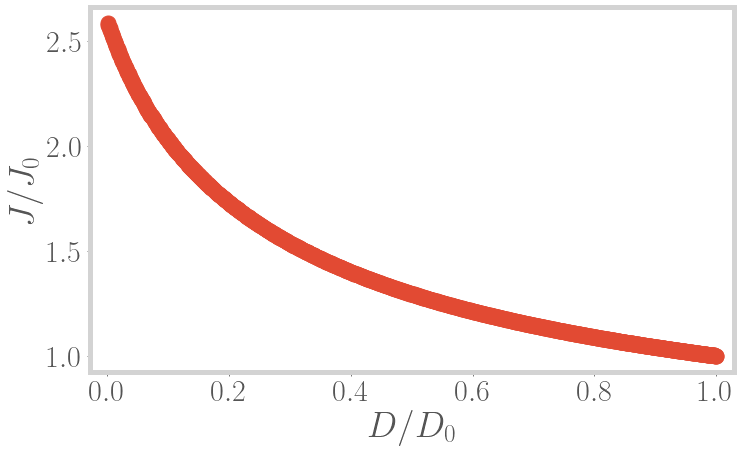

In [3]:
def get_RG_flow(J0_by_D0, Ub_by_J=0, plot=False):
    """ Returns the flow of couplings in the form of two ndarrays J and D.
    Each ndarray is in ascending order of the bandwidth. """
    J0 = D0 * J0_by_D0
    Ub = - Ub_by_J * J0
    omega = -D0/2
    
    ### initialise arrays with UV values
    D = [D0]
    J = [J0]
    
    ### apply URG transformations until bandwith vanishes
    ### or J reduces to zero.
    while D[-1] >= deltaD and J[-1] >= 0:
        
        ### URG equation
        deltaJ = - J[-1] * (J[-1] + 4 * Ub) / (omega - D[-1]/2 + J[-1]/4) * deltaD
        
        ### Check if denominator has changed sign, 
        ### then append renormalised values to array
        if (omega - (D[-1] - deltaD)/2 + (J[-1] + deltaJ)/4) * (omega - D0/2 + J0/4) > 0:
            D.append(D[-1] - deltaD)
            J.append(J[-1] + deltaJ)
        else:
            break
    
    ### plot values
    if plot:
        plt.plot(np.array(D)/D0, np.array(J)/J0, marker="o")
        plt.xlabel(r"$D/D_0$")
        plt.ylabel(r"$J/J_0$")
    print (len(J), D0/deltaD)
    return np.flip(D), np.flip(J)

_ = get_RG_flow(0.35, Ub_by_J=0, plot=True)
# print (D[0]/deltaD, J[0], D[0])

In [7]:
def get_init_weight(args):
    comb, total_num, c_all, Xgs = args
    classicalState = tensor([basis(2, 1 - int(comb[0]))] + [basis(2,0)] * (total_num - 1))
    for i,occ in enumerate(comb):
        if i == 0:
            continue
        classicalState = [1, c_all[i - 1].dag()][int(occ)] * classicalState
    weight = np.real(Xgs.dag() * classicalState)[0][0]
    if np.round(weight, 5) != 0:
        return comb, 2 * (comb[0] - 0.5) * abs(weight)
        # return comb, weight
    else:
        return
    
def init_wavefunction(J, D, num_in, part_hole_sectors):
    """ Generates the initial wavefunction at the fixed point.
    Returns the coefficients associated with it and the list
    of all possible occupancies for each of the members.
    No IOMS are taken into account at this point."""
    
    total_num = 1 + 2 * num_in
    c_all = [tensor([identity(2)] + [sigmaz()]*(i) + [destroy(2)] + [identity(2)]*(total_num - 1 - i - 1)) for i in range(total_num - 1)]
    num_kup = [c.dag() * c for c in c_all[::2]]
    num_kdn = [c.dag() * c for c in c_all[1::2]]
    sigmadz = tensor([sigmaz()] + [identity(2)] * (total_num - 1))
    sigmadp = tensor([sigmap()] + [identity(2)] * (total_num - 1))
    sigmadm = sigmadp.dag()
    
    c0up = sum(c_all[::2])
    c0dn = sum(c_all[1::2])
    sigma0z = c0up.dag() * c0up - c0dn.dag() * c0dn
    c0up /= (sigma0z**2).tr()**0.25
    c0dn /= (sigma0z**2).tr()**0.25
    
    sigma0z = c0up.dag() * c0up - c0dn.dag() * c0dn
    
    if 'p' in part_hole_sectors and 'h' in part_hole_sectors:
        Ek = np.linspace(-D, D, num_in)
    elif 'p' not in part_hole_sectors and 'h' in part_hole_sectors:
        Ek = np.linspace(deltaD, D, num_in)
    elif 'p' in part_hole_sectors and 'h' not in part_hole_sectors:
        Ek = np.linspace(-D, -deltaD, num_in)
    Ek = np.linspace(deltaD, D, num_in)
    H = sum([Ek[i] * (num_kup[i] + num_kdn[i]) for i in range(len(num_kup))]) \
            + J * (0.25 * sigmadz * sigma0z
            + 0.5 * sigmadp * c0dn.dag() * c0up
            + 0.5 * sigmadm * c0up.dag() * c0dn
                  )
    E, X = H.eigenstates()
    print (E[0])
    Xgs_q = X[0]
    assert (Xgs_q.dag() * sigmadz * Xgs_q)[0][0] == 0
    assert False not in [(Xgs_q.dag() * (num_kup[i] - num_kdn[i]) * Xgs_q)[0][0] == 0 for i in range(len(num_kup))]
        
    args = [[comb, total_num, c_all, Xgs_q] for comb in product([1,0], repeat=total_num)]
    results = list(tqdm(Pool().imap(get_init_weight, args), total=2**total_num))
    combinations = np.array([r[0] for r in results if r!= None])
    coefficients = np.array([r[1] for r in results if r!= None])
    
    return coefficients/np.linalg.norm(coefficients), combinations


def get_renorm_per_comb(args_arr):
    target_combs = []
    target_renorm = []
    for args in args_arr:
        source_comb, q_pos, alpha, coeff = args
        
        ### loop over spins of IOM, particle/hole sectors as well as cloud members
        for beta, k_pos in product([1, -1], range(1, q_pos - 1, 2)):
            beta_pos = int((1 - beta) / 2)
            betabar_pos = int(1 - beta_pos)
            if  source_comb[k_pos + beta_pos] == 1 - source_comb[q_pos + beta_pos]:
                target_comb = np.copy(source_comb)
                target_comb[k_pos + beta_pos] = 1 - source_comb[k_pos + beta_pos]
                target_comb[q_pos + beta_pos] = 1 - source_comb[q_pos + beta_pos]
                exchange_sign = (-1) ** (1 - source_comb[q_pos + beta_pos]) * (-1) ** sum(source_comb[k_pos:q_pos])
                target_combs.append(target_comb)
                target_renorm.append(exchange_sign * alpha * beta * (source_comb[0] - 0.5) * coeff)
            if  source_comb[k_pos + betabar_pos] == 1 - source_comb[q_pos + beta_pos] and source_comb[0] == 1 - abs((1 - beta)/2 - source_comb[q_pos + beta_pos]):
                target_comb = np.copy(source_comb)
                target_comb[k_pos + betabar_pos] = 1 - source_comb[k_pos + betabar_pos]
                target_comb[q_pos + beta_pos] = 1 - source_comb[q_pos + beta_pos]
                target_comb[0] = 1 - source_comb[0]
                exchange_sign = (-1) ** (1 - source_comb[q_pos + beta_pos]) * (-1) ** sum(source_comb[k_pos:q_pos])
                target_combs.append(target_comb)
                # target_renorm.append(exchange_sign * alpha * beta * (source_comb[0] - 0.5) * coeff)
                target_renorm.append(exchange_sign * alpha * coeff)
    return target_combs, target_renorm


def get_renorm(coefficients, combinations, savepath, ioms, alpha):
    """ Calculates and returns the renormalised coefficients at a given RG step. """
    q_pos = len(combinations[0]) ### position of the nearest IOM
    combinations = np.array([list(c) + ioms for c in combinations])
    new_combinations = np.copy(combinations)
    new_coefficients = np.copy(coefficients)

    args = [[source_comb, q_pos, alpha, coefficients[(combinations == source_comb).all(axis=1).nonzero()][0]] for source_comb in combinations]
    target_combs, target_renorm = Pool().apply_async(get_renorm_per_comb, (args, )).get()
    for tcomb,trenorm in zip(target_combs, target_renorm):
        if list(tcomb) not in new_combinations.tolist():
            new_combinations = np.vstack([new_combinations, tcomb])
            new_coefficients = np.append(new_coefficients, 0)
        new_coefficients[(new_combinations == tcomb).all(axis=1).nonzero()] += trenorm

    ### normalise the final coefficients
    new_coefficients /= np.linalg.norm(new_coefficients)

    return new_coefficients, new_combinations


def get_tensorRG(J0_by_D0, num_in, num_out, part_hole_sectors, computables):

    D, J = get_RG_flow(J0_by_D0)
    num_in_start = num_in
    print ("Starting with", len(part_hole_sectors) * num_in, "k-states in the bath.") 
    omega = -D0/2
    
    ### ensure that there are enugh RG steps in J and D
    ### to recouple all IOMS.
    assert len(J) >= num_out + 1
    
    ### obtain the initial coefficients and set of occupancies
    savepath = "./MERGCoeffs/{:.0f},{:.0f},{:.10f},{:.10f},{:.10f},{:.10f}".format(round(D[0]/deltaD), 
                                                                                   1 + 2 * num_in * len(part_hole_sectors), J0_by_D0 * D0, D0, deltaD, omega)
    try:
        raise ValueError('A very bad thing happened.')
        coefficients_init = np.load(savepath + "-coeff.npz")['arr_0']
        combinations_init = np.load(savepath + "-combs.npz")['arr_0']
    except:
        coefficients_init, combinations_init = init_wavefunction(J[0], D[0], num_in, part_hole_sectors)
        os.makedirs("./MERGCoeffs", exist_ok=True)
        np.savez_compressed(savepath + "-coeff.npz", coefficients_init)
        np.savez_compressed(savepath + "-combs.npz", combinations_init)
    ### save the initial set of coefficients and store the savepath
    ### in the list of savepaths that will be finally returned.

    savepaths = [""] * (1 + num_out)
    savepaths[0] = savepath
    
    computations = {computable: [] for computable, members, _, _ in computables}
    ### initial the next set of coefficients and loop through 
    ### the RG flow to generate the tensor network RG.
    
    coefficients_arr = [coefficients_init] * len(part_hole_sectors)
    combinations_arr = [combinations_init] * len(part_hole_sectors)
    for i, (Ji, Di) in tqdm(enumerate(zip(J[1: num_out + 1], D[1: num_out + 1])), total=num_out, desc="Applying inverse unitaries"):
        total_num = 1 + 2 * (num_in + 1) * len(part_hole_sectors)
        alpha = Ji / (omega - Di/2 + Ji/4)
        savepath = "./MERGCoeffs/{:.0f},{:.0f},{:.10f},{:.10f},{:.10f},{:.10f}".format(round(D[0]/deltaD), total_num, Ji, Di, deltaD, omega)

        ### get the next set of coefficients and append the savepath to access them later.

        coefficients = []
        combinations = []
        for j,sector in enumerate(part_hole_sectors):
            ioms = [1,1] if sector == 'p' else [0,0]
            coefficients_j, combinations_j = get_renorm(coefficients_arr[j], combinations_arr[j], savepath, ioms, alpha)
            coefficients_arr[j] = coefficients_j
            combinations_arr[j] = combinations_j
            coefficients = np.append(coefficients, coefficients_j)
            combinations += combinations_j.tolist()
        
        ### Save (with compression!)
        savepaths[i + 1] = savepath
        # print (combinations)
        np.savez_compressed(savepath + "-coeff.npz", coefficients)
        np.savez_compressed(savepath + "-combs.npz", combinations)

        ### increase the number of entangled members.
        num_in += 1
    
    for computable, members, ylabel, savename in computables:
        if computable == "VNE":
            args = [[savepath, members] for savepath in savepaths]
            computations[computable] = list(tqdm(Pool(1).imap(get_VNE_perstep, args), total=len(savepaths)))

        if computable == "I2":
            assert len(members) == 2
            args1 = [[savepath, members[0]] for savepath in savepaths]
            S1 = list(tqdm(Pool().imap(get_VNE_perstep, args1), total=len(savepaths)))
            args2 = [[savepath, members[1]] for savepath in savepaths]
            S2 = list(tqdm(Pool().imap(get_VNE_perstep, args2), total=len(savepaths)))
            args12 = [[savepath, list(members[0]) + list(members[1])] for savepath in savepaths]
            S12 = list(tqdm(Pool().imap(get_VNE_perstep, args12), total=len(savepaths)))
            computations[computable] = np.array(S1) + np.array(S2) - np.array(S12)

        if computable == "Qtemp":
            args = [[savepath, members] for savepath in savepaths]
            computations[computable] = list(tqdm(Pool().imap(get_Qtemp_perstep, args), total=len(savepaths)))
            
        if computable == "dist":
            assert len(members) == 2
            args1 = [[savepath, members[0]] for savepath in savepaths]
            S1 = list(tqdm(Pool().imap(get_VNE_perstep, args1), total=len(savepaths)))
            args2 = [[savepath, members[1]] for savepath in savepaths]
            S2 = list(tqdm(Pool().imap(get_VNE_perstep, args2), total=len(savepaths)))
            args12 = [[savepath, list(members[0]) + list(members[1])] for savepath in savepaths]
            S12 = list(tqdm(Pool().imap(get_VNE_perstep, args12), total=len(savepaths)))
            I2 = np.array(S1) + np.array(S2) - np.array(S12)
            computations[computable] = np.log(np.log(2**(len(members[0]) + len(members[1]) - 1)) / I2)
            
        if computable == "variance":
            variance = []
            for savepath in savepaths:
                coefficients = np.load(savepath + "-coeff.npz")['arr_0']
                variance.append(np.var(coefficients))
            computations[computable] = variance
    
    
        if computable == "elements_rhok":
            args = [[savepath, members] for savepath in savepaths]
            data_arr = [data for data in tqdm(Pool().imap(get_rhok_perstep, args), total=len(savepaths))]
            for x, data in zip(range(num_in_start, num_in_start + num_out + 1), data_arr):
                for i,rho_ki in enumerate(np.array(data[1].diag()).flatten()):
                    plt.scatter(x, rho_ki, color=cols[i], marker=markers[i])
            [plt.scatter([], [], color=cols[i], marker=markers[i], label=''.join(map(str, data[0][i]))) for i in range(2**len(members))]
            plt.xlabel(r"no. of $k-$states in the c-bath")
            plt.ylabel(ylabel)
            plt.legend()
            plt.savefig(savename, bbox_inches='tight')
            plt.show()
            computations[computable] = []
            
            
        if computable == "S_kz":
            assert len(members) == 1
            for savepath in savepaths:
                coefficients = np.load(savepath + "-coeff.npz")['arr_0']
                combinations = np.load(savepath + "-combs.npz")['arr_0']
                computations[computable].append(0.5 * sum(coefficients[combinations[:,members[0]] == 1]**2)
                                                - 0.5 * sum(coefficients[combinations[:,members[0] + 1] == 1]**2))
                
        if computable == "complexity":
            for savepath in savepaths:
                combinations = np.load(savepath + "-combs.npz")['arr_0']
                computations[computable].append(len(combinations)/2**len(combinations[0]))
        
        if len(computations[computable]) > 0:
            plt.scatter(range(num_in_start, num_in_start + num_out + 1), np.round(computations[computable], 10))
            plt.xlabel(r"no. of $k-$states in the c-bath")
            plt.ylabel(ylabel)
            plt.savefig(savename, bbox_inches='tight')
            plt.show()
    return computations


def get_rhok_perstep(args):
    """Returns the VNE at a given RG step."""

    savepath, members = args
    ### Access the coefficients data for the given RG step.
    coefficients = np.load(savepath + "-coeff.npz")['arr_0']
    combinations = np.load(savepath + "-combs.npz")['arr_0']

    ### Create the reduced density matrix by adding 
    ### the pertinent coefficients.
    rho_reduced = np.zeros([2**len(members)] * 2)
    members_combs = [list(comb) for comb in product([1,0], repeat=len(members))]

    for i,combination in enumerate(np.copy(combinations)):
        x_index = list(members_combs).index(list(combination[members]))
        rho_reduced[x_index][x_index] += coefficients[i]**2
        new_comb = combination[::]
        for y_index, mem_comb in enumerate(members_combs):
            if y_index == x_index: continue
            new_comb[members] = mem_comb
            if list(new_comb) in [list(c) for c in combinations]:
                j = [list(c) for c in combinations].index(list(new_comb))
                rho_reduced[x_index][y_index] += coefficients[i] * coefficients[j]
    rho_red_qutip = Qobj(rho_reduced, dims = [[2] * len(members)] * 2).unit()
    
    return members_combs, rho_red_qutip


def get_VNE_perstep(args):
    """Returns the VNE at a given RG step."""

    savepath, members = args
    ### Access the coefficients data for the given RG step.
    coefficients = np.load(savepath + "-coeff.npz")['arr_0']
    combinations = np.load(savepath + "-combs.npz")['arr_0']
    # print (combinations[0])
    
    ### Create the reduced density matrix by adding 
    ### the pertinent coefficients.
    rho_reduced = np.zeros([2**len(members)] * 2)
    members_combs = [list(comb) for comb in product([1,0], repeat=len(members))]

    for i,combination in enumerate(np.copy(combinations)):
        x_index = list(members_combs).index(list(combination[members]))
        rho_reduced[x_index][x_index] += coefficients[i]**2
        new_comb = combination[::]
        for y_index, mem_comb in enumerate(members_combs):
            if y_index == x_index: continue
            new_comb[members] = mem_comb
            if list(new_comb) in [list(c) for c in combinations]:
                j = [list(c) for c in combinations].index(list(new_comb))
                rho_reduced[x_index][y_index] += coefficients[i] * coefficients[j]
    rho_red_qutip = Qobj(rho_reduced, dims = [[2] * len(members)] * 2)
    SEE = entropy_vn(rho_red_qutip.unit())
    
    return SEE


def get_Qtemp_perstep(args):
    """Returns the VNE at a given RG step."""

    savepath, member = args
    ### Access the coefficients data for the given RG step.
    coefficients = np.load(savepath + "-coeff.npz")['arr_0']
    combinations = np.load(savepath + "-combs.npz")['arr_0']

    ### Create the reduced density matrix by adding 
    ### the pertinent coefficients.
    rho_reduced = np.zeros([2,2])
    
    
    rho_reduced[0][0] = sum(coefficients[combinations[:,member] == 0]**2)
    rho_reduced[1][1] = sum(coefficients[combinations[:,member] == 1]**2)

    ### Diagonalise reduced DM and return VNE.
    
    eigvals = np.linalg.eigvalsh(rho_reduced)

    return np.log(abs(rho_reduced[1][1] / rho_reduced[0][0]))

1000 1000.0
Starting with 6 k-states in the bath.
-0.009952373589718922


  0%|          | 0/128 [00:00<?, ?it/s]

Applying inverse unitaries:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

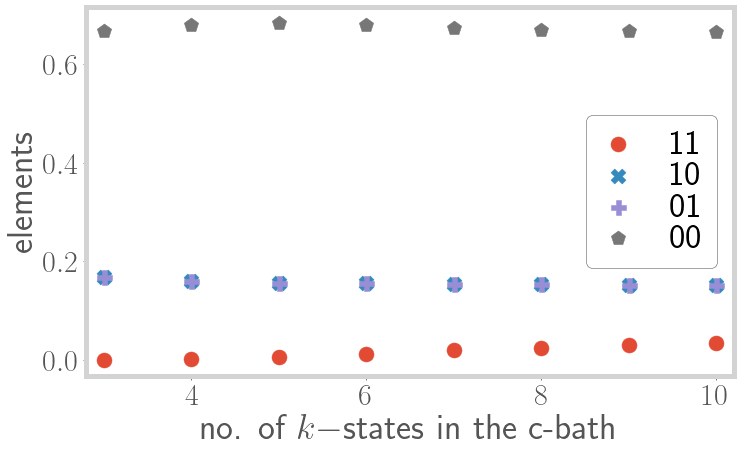

  0%|          | 0/8 [00:00<?, ?it/s]

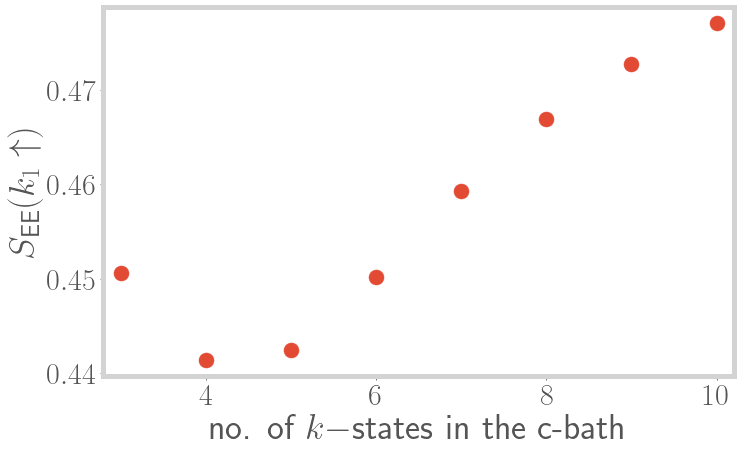

  0%|          | 0/8 [00:00<?, ?it/s]

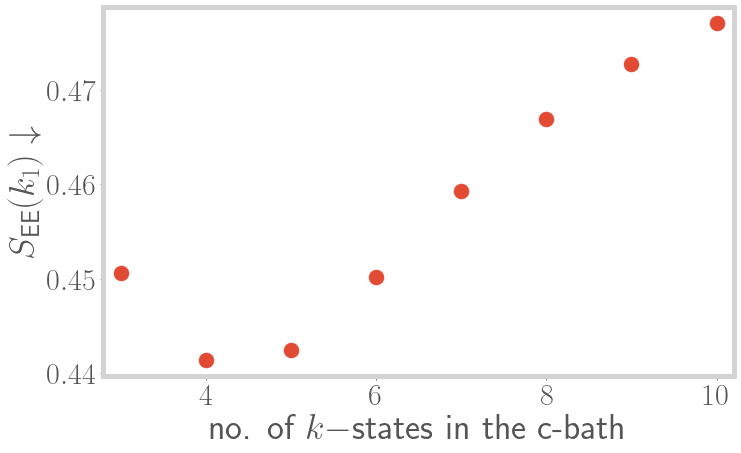

In [8]:
computations = get_tensorRG(0.1, 3, 7, ['h', 'p'], [
    ['elements_rhok', [1, 2], r"elements", "rhok.pdf"],
    ['VNE', [1], r"$S_\text{EE}(k_1\uparrow)$", "VNE_kup.pdf"],
    ['VNE', [2], r"$S_\text{EE}(k_1)\downarrow$", "VNE_kdn.pdf"],
])

## **Benchmarks against a more "brute-force" approach**

In [ ]:
def bruteForceMERG(J0_by_D0, num_in, num_out):
    omega = -D0/2
    num_in_start = num_in
    D, J = get_RG_flow(J0_by_D0)
    assert len(J) >= num_out + 1
    total_dim = 1 + 2 * (num_in + num_out)
    c_all = [tensor([identity(2)] + [sigmaz()]*(i) + [destroy(2)] + [identity(2)]*(total_dim - i - 2)) for i in range(total_dim - 1)]
    Sdz = 0.5 * tensor([sigmaz()] +  [identity(2)] * (total_dim - 1))
    Sdp = tensor([sigmap()] +  [identity(2)] * (total_dim - 1))
    Sdm = Sdp.dag()
    vacuum = tensor([basis(2,0)]*total_dim)
    init_state = 0
    for k_pos in range(0, 2 * num_in, 2):
        init_state += c_all[k_pos + 1].dag() * vacuum
        init_state += - Sdm * c_all[k_pos].dag() * vacuum
    gstates = [init_state.unit()]
    ref_state1 = c_all[3].dag() * vacuum
    ref_state2 = Sdm * c_all[2].dag() * vacuum
    ref_state3 = c_all[5].dag() * vacuum
    ref_state4 = Sdm * c_all[4].dag() * vacuum
    ref_state5 = Sdm * c_all[0].dag() * vacuum
    ref_state6 = c_all[1].dag() * vacuum

    for Ji, Eq in tqdm(zip(J[1:num_out+1], D[1:num_out+1]), total=num_out):
        q_pos = 2 * num_in
        alpha = Ji / (omega - Eq/2 + Ji/4)
        eta = 0
        eta_dag = 0
        for k_pos in range(0, q_pos, 2):
            for beta in [1, -1]:
                beta_pos = 0 if beta == 1 else 1
                eta += alpha * Sdz * beta * c_all[k_pos + beta_pos].dag() * c_all[q_pos + beta_pos]
                eta += alpha * [Sdp, Sdm][beta_pos] * c_all[k_pos + 1 - beta_pos].dag() * c_all[q_pos + beta_pos]
                eta_dag += alpha * Sdz * beta * c_all[q_pos + beta_pos].dag() * c_all[k_pos + beta_pos]
                eta_dag += alpha * [Sdp, Sdm][1 - beta_pos] * c_all[q_pos + beta_pos].dag() * c_all[k_pos + 1 - beta_pos]
        gstates.append(((1 + eta + eta_dag) * gstates[-1]).unit())

        num_in += 1
    
    vne_arr = []
    I2_arr = []
    for state in tqdm(gstates):
        rho = state * state.dag().unit()
        rho_k = rho.ptrace([1])
        rho_d = rho.ptrace([0])
        rho_dk = rho.ptrace([0, 1])
        SEE_k = entropy_vn(rho_k)
        SEE_d = entropy_vn(rho_d)
        SEE_dk = entropy_vn(rho_dk)
        I2_dk = SEE_k + SEE_d - SEE_dk
        vne_arr.append(SEE_k)
        I2_arr.append(I2_dk)                   
    print (vne_arr)
    print (I2_arr)

    computations = get_tensorRG(J0_by_D0, num_in_start, num_out + 5, [['VNE', [1], r"$S_\text{EE}(k_1)$", "VNE_k.pdf"],
                                                                      ['I2', [[0], [1]], r"$I_2(d:k_1)$", "I2_dk.pdf"]])
    plt.scatter(range(num_in_start, num_in_start + num_out + 1), vne_arr, color=cols[1], zorder=99, label="slower approach")
    plt.plot(range(num_in_start, num_in_start + len(computations['VNE'])), computations['VNE'], label="faster approach")
    plt.ylabel(r"$S_\text{{EE}}(k)$")
    plt.xlabel(r"no. of $k-$states in the c-bath")
    plt.text(0.2, 0.2, r"$n_\text{{IR}}={:.0f}$".format(num_in_start), bbox=bbox, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.legend()
    plt.savefig("comparison_VNE_{:.0f}.pdf".format(num_in_start), bbox_inches='tight')
    plt.show()
    plt.scatter(range(num_in_start, num_in_start + num_out + 1), I2_arr, color=cols[1], zorder=99, label="slower approach")
    plt.plot(range(num_in_start, num_in_start + len(computations['I2'])), computations['I2'], label="faster approach")
    plt.ylabel(r"$I_2(d:k)$")
    plt.xlabel(r"no. of $k-$states in the c-bath")
    plt.text(0.2, 0.2, r"$n_\text{{IR}}={:.0f}$".format(num_in_start), bbox=bbox, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.legend()
    plt.savefig("comparison_I2_{:.0f}.pdf".format(num_in_start), bbox_inches='tight')
    plt.show()

bruteForceMERG(0.1, 1, 6)
bruteForceMERG(0.1, 3, 4)